In [1]:
import matplotlib.pyplot as plt
import cantera as ct

print(f"Running Cantera version: {ct.__version__}")

Running Cantera version: 3.1.0


In [2]:
gas = ct.Solution("data/n-hexane-NUIG-2015.yaml")

/tmp/ipykernel_47030/2273275873.py:1: UserWarning: NasaPoly2::validate: 
For species OHV, discontinuity in h/RT detected at Tmid = 1000
	Value computed using low-temperature polynomial:  53.62056162666667
	Value computed using high-temperature polynomial: 53.5841554314

  gas = ct.Solution("data/n-hexane-NUIG-2015.yaml")
/tmp/ipykernel_47030/2273275873.py:1: UserWarning: NasaPoly2::validate: 
For species CHV, discontinuity in h/RT detected at Tmid = 1000
	Value computed using low-temperature polynomial:  107.5046684
	Value computed using high-temperature polynomial: 107.34847808033332

  gas = ct.Solution("data/n-hexane-NUIG-2015.yaml")


In [3]:
pres = 1.046138 * ct.one_atm  # in atm. This equals 1.06 bars
conc0 = {"NC7H16": 0.005, "O2": 0.0275, "HE": 0.9675}

tau = 2  # s
vol = 30.5 * (1e-2) ** 3  # m3

In [4]:
# Define all the temperatures at which we will run simulations. These should overlap
# with the values reported in the paper as much as possible
temps = [650, 700, 750, 775, 825, 850, 875, 925, 950, 1075, 1100]

# Create a SolutionArray to store values for the above points
solns = ct.SolutionArray(gas)

In [5]:
conc = conc0

for temp in temps:
    # Use concentrations from the previous iteration to speed up convergence
    gas.TPX = temp, pres, conc

    # inlet -> flow_control -> reactor -> pres_control -> exhaust
    reactor = ct.IdealGasReactor(gas, energy="off", volume=vol)
    exhaust = ct.Reservoir(gas)
    inlet = ct.Reservoir(gas)
    flow_control = ct.MassFlowController(
        upstream=inlet,
        downstream=reactor,
        mdot=reactor.mass / tau,
    )
    pres_control = ct.PressureController(
        upstream=reactor, downstream=exhaust, primary=flow_control,
        K=1e-3,
    )
    reactor_net = ct.ReactorNet([reactor])
    reactor_net.advance_to_steady_state()
    print(f"Simulation at T={temp} K complete")

    conc = reactor.thermo.X
    solns.append(reactor.thermo.state)

Simulation at T=650 K complete
Simulation at T=700 K complete
Simulation at T=750 K complete
Simulation at T=775 K complete
Simulation at T=825 K complete
Simulation at T=850 K complete
Simulation at T=875 K complete
Simulation at T=925 K complete
Simulation at T=950 K complete
Simulation at T=1075 K complete
Simulation at T=1100 K complete


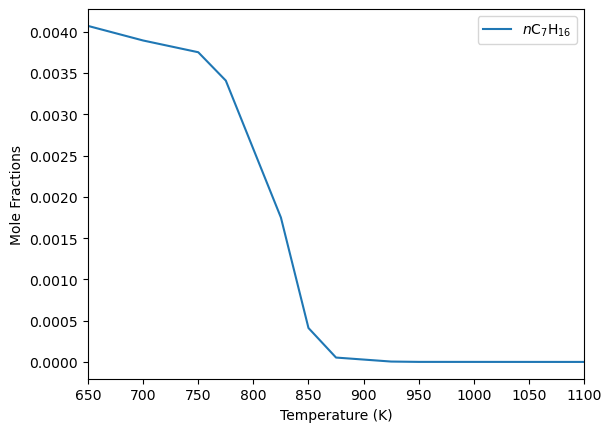

In [6]:
plt.figure()
plt.plot(
    solns.T, solns("NC7H16").X, color="C0", label="$n$C$_{7}$H$_{16}$"
)

plt.xlabel("Temperature (K)")
plt.ylabel(r"Mole Fractions")

plt.xlim([650, 1100])
plt.legend(loc=1)